# Using the trained weights in an ensemble of neurons
- On the function points branch of nengo
- On the vision branch of nengo_extras

In [2]:
import nengo
import numpy as np
import pickle
from nengo_extras.data import load_mnist
from nengo_extras.vision import Gabor, Mask
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import scipy.ndimage

Load the MNIST database

In [3]:
# --- load the data
img_rows, img_cols = 28, 28

(X_train, y_train), (X_test, y_test) = load_mnist()

X_train = 2 * X_train - 1  # normalize to -1 to 1
X_test = 2 * X_test - 1  # normalize to -1 to 1


Each digit is represented by a one hot vector where the index of the 1 represents the number

In [4]:
temp = np.diag([1]*10)

ZERO = temp[0]
ONE =  temp[1]
TWO =  temp[2]
THREE= temp[3]
FOUR = temp[4]
FIVE = temp[5]
SIX =  temp[6]
SEVEN =temp[7]
EIGHT= temp[8]
NINE = temp[9]

labels =[ZERO,ONE,TWO,THREE,FOUR,FIVE,SIX,SEVEN,EIGHT,NINE]

dim =28

Load the saved weight matrices that were created by trainging the model

In [6]:
label_weights = pickle.load(open("label_weights_5000.p", "rb"))
activity_to_img_weights = pickle.load(open("activity_to_img_weights5000.p", "rb"))
identity_after_encoder_weights =  pickle.load(open("identity_after_encoder_weights5000.p", "rb"))
#rotated_after_encoder_weights_5000 =  cPickle.load(open("rotated_after_encoder_weights_5000.p", "r"))

#rotation_weights = cPickle.load(open("rotation_weights_clockwise5000.p","rb"))

#label_weights = cPickle.load(open("label_weights_rot_enc5000.p", "rb"))
#activity_to_img_weights = cPickle.load(open("activity_to_img_weights_rot_enc5000.p", "r"))
#rotated_after_encoder_weights =  cPickle.load(open("rotated_counter_after_encoder_weights_rot_enc5000.p", "r"))

## The network where the mental imagery occurs
- The state, seed and ensemble parameters (including encoders) must all be the same for the saved weight matrices to work
- The number of neurons (n_hid) must be the same as was used for training
- The input must be shown for a short period of time to be able to view the image
- The recurrent connection must be from the neurons because the weight matices were trained on the neuron activities


In [17]:
rng = np.random.RandomState(9)
n_hid = 5000
model = nengo.Network(seed=3)
with model:
    #Stimulus only shows for brief period of time
    stim = nengo.Node(lambda t: THREE if t < 1 else 0) #nengo.processes.PresentInput(labels,1))#
    
    ens_params = dict(
        eval_points=X_train,
        neuron_type=nengo.LIF(),
        intercepts=nengo.dists.Choice([-0.5]),
        max_rates=nengo.dists.Choice([100]),
        )
        
    
    # linear filter used for edge detection as encoders, more plausible for human visual system
    encoders = Gabor().generate(n_hid, (11, 11), rng=rng)
    encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)

    
    ens = nengo.Ensemble(n_hid, dim**2, seed=3, encoders=encoders, **ens_params)
    
    #Recurrent connection on the neurons of the ensemble to maintain the image
    #nengo.Connection(ens.neurons, ens.neurons, transform = identity_after_encoder_weights.T, synapse=0.2)      
    #Can't just connect neurons to neurons
    #nengo.Connection(ens.neurons, ens.neurons, synapse=0.2)      

    #Connect stimulus to ensemble, transform using learned weight matrices
    nengo.Connection(stim, ens, transform = np.dot(label_weights,activity_to_img_weights).T, synapse=0.1)
    
    #Collect output, use synapse for smoothing
    probe = nengo.Probe(ens.neurons,synapse=0.1)
    

In [18]:
sim = nengo.Simulator(model)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [19]:
sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

## The following is not part of the brain model, it is used to view the output for the ensemble
Since it's probing the neurons themselves, the output must be transformed from neuron activity to visual image

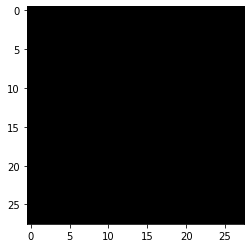

In [20]:
'''Animation for Probe output'''
fig = plt.figure()

output_acts = []
for act in sim.data[probe]:
    output_acts.append(np.dot(act,activity_to_img_weights))

def updatefig(i):
    im = pylab.imshow(np.reshape(output_acts[i],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'),animated=True)
    
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=0.1, blit=True)
plt.show()

5000


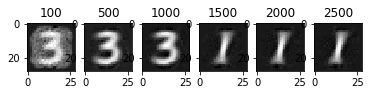

In [21]:
print(len(sim.data[probe]))

plt.subplot(161)
plt.title("100")
pylab.imshow(np.reshape(output_acts[100],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(162)
plt.title("500")
pylab.imshow(np.reshape(output_acts[500],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(163)
plt.title("1000")
pylab.imshow(np.reshape(output_acts[1000],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(164)
plt.title("1500")
pylab.imshow(np.reshape(output_acts[1500],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(165)
plt.title("2000")
pylab.imshow(np.reshape(output_acts[2000],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(166)
plt.title("2500")
pylab.imshow(np.reshape(output_acts[2500],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

plt.show()

Pickle the probe's output if it takes a long time to run

In [ ]:
#The filename includes the number of neurons and which digit is being rotated
filename = "mental_rotation_output_ONE_"  + str(n_hid) + ".p"
cPickle.dump(sim.data[probe], open( filename , "wb" ) )

## Testing

In [ ]:
testing = np.dot(ONE,np.dot(label_weights,activity_to_img_weights))
plt.subplot(121)
pylab.imshow(np.reshape(testing,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

#Get image
testing = np.dot(ONE,np.dot(label_weights,activity_to_img_weights))


#Get activity of image
_, testing_act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=testing)

#Get rotated encoder outputs
testing_rotate = np.dot(testing_act,rotated_after_encoder_weights)

#Get activities
testing_rotate = ens.neuron_type.rates(testing_rotate, sim.data[ens].gain, sim.data[ens].bias)

for i in range(5):
    testing_rotate = np.dot(testing_rotate,rotated_after_encoder_weights)
    testing_rotate = ens.neuron_type.rates(testing_rotate, sim.data[ens].gain, sim.data[ens].bias)


#testing_rotate = np.dot(testing_rotate,rotation_weights)

testing_rotate = np.dot(testing_rotate,activity_to_img_weights)

plt.subplot(122)
pylab.imshow(np.reshape(testing_rotate,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

plt.show()

In [ ]:

plt.subplot(121)
pylab.imshow(np.reshape(X_train[0],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

#Get activity of image
_, testing_act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=X_train[0])

testing_rotate = np.dot(testing_act,activity_to_img_weights)

plt.subplot(122)
pylab.imshow(np.reshape(testing_rotate,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

plt.show()